# Exercise 4-2: Spike Sorting

Distance Measures on Neural Spikes
==================================


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def get_filename(file_index):
    """
    Returns the filename and description based on the file index.

    Parameters:
        file_index (int): Index of the file (1-5).

    Returns:
        tuple: (filename, description)
    """
    if file_index == 1:  # Task a)
        return "./csv/pulsed-signals-01-no-artifact.csv"
    elif file_index == 2:  # Task b)
        return "./csv/pulsed-signals-02-motion-artifact.csv"
    elif file_index == 3:  # Task c)
        return "./csv/pulsed-signals-03-motion-artifact-inversion.csv"
    elif file_index == 4:  # Task d)
        return "./csv/pulsed-signals-04-baseline-drift.csv"
    elif file_index == 5:  # Task e)
        return "./csv/pulsed-signals-05-strong-distortion.csv"
    else:
        raise ValueError("Invalid file index. Choose a value between 1 and 5.")   

In [47]:
def plot_spike_detection(FILENAME, y, K, indices_spikes, REF_INDEX, SPIKE_WIDTH, 
                         indices_spikes_detected, neuron_sources, distances_sq, 
                         DISTANCE_THRESHOLD, TOP_DISTANCE_TRESHOLD, METHOD_STR, SAVE_FIGURE=False, file_index=0):
    """
    Function to plot spike detection with subplots for signal observation, detected spikes, and distance measure.

    Parameters:
        FILENAME (str): Name of the data file.
        y (array): Signal data.
        K (int): Total number of samples.
        indices_spikes (array): Indices of spikes in the signal.
        REF_INDEX (int): Index of the reference spike.
        SPIKE_WIDTH (int): Width of each spike.
        indices_spikes_detected (array): Indices of detected spikes.
        neuron_sources (array): Array with neuron source labels for each spike.
        distances_sq (array): Distance measure for each spike.
        DISTANCE_THRESHOLD (float): Threshold for detecting spikes based on distance measure.
        METHOD_STR (str): Method description (e.g., "Euclidean Distance").
        SAVE_FIGURE (bool): If True, saves the plot as a PNG file.
        file_index (int): Index for saving the file (used in filename).
    """
    fig = plt.figure(figsize=(14, 6), constrained_layout=True)
    spec = fig.add_gridspec(3, 1)
    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, :], sharex=ax0)
    ax2 = fig.add_subplot(spec[2, :], sharex=ax0)

    plt.suptitle("File: " + FILENAME)

    # -- Subplot 1 : plot signal with projections --
    ax0.set_title("Observed Signal")
    ax0.plot(range(K), y, lw=0.5, c='tab:gray', label='observation')
    ax0.scatter(indices_spikes, np.ones_like(indices_spikes) * y.min(), marker=2, c='tab:gray')  # markers & reference marker
    k_ref = indices_spikes[REF_INDEX]
    ax0.plot(range(SPIKE_WIDTH) + k_ref, y[range(SPIKE_WIDTH) + k_ref], lw=1.25, c='b', label='reference spike') 
    ax0.legend(loc="upper right")

    # -- Subplot 2 : plot signal with detected pulses --
    ax1.set(title="Detected Spikes. Method: " + METHOD_STR)
    ax1.plot(range(K), y, lw=0.5, c='gray', label='observation')
    ax1.scatter(indices_spikes, np.ones_like(indices_spikes) * y.min(), marker=2, c='tab:gray')  # markers & reference marker
    for k0 in indices_spikes_detected:  # draw projected polynomials
        lastline, = ax1.plot(range(SPIKE_WIDTH) + k0, y[range(SPIKE_WIDTH) + k0], lw=0.75, c='r') 
    lastline.set_label('spike')
    for index_spike in indices_spikes:  # add spike source labels    
        ax1.annotate(str(neuron_sources[index_spike]), (index_spike, y.min()), ha='center', va='top')
    ax1.set(xlabel='k', ylabel=r'$y$')
    ax1.set_ylim([y.min() - 0.05, y.max()])
    ax1.legend(loc="upper right")

    # -- Subplot 3 : plot distance measure with threshold (dashed line) --
    ax2.set(title="Distance Measure")
    ax2.stem(indices_spikes, distances_sq, 'k', markerfmt='ko', label='distance')
    ax2.axhline(y=DISTANCE_THRESHOLD, ls='--', lw=0.5, c='k', label="threshold: " + str(DISTANCE_THRESHOLD))
    if(TOP_DISTANCE_TRESHOLD != 0):
        ax2.axhline(y=TOP_DISTANCE_TRESHOLD, ls='--', lw=0.5, c='k', label="threshold: " + str(TOP_DISTANCE_TRESHOLD))
    ax2.legend(loc="upper right")

    # Show the plots
    plt.show()

    # ------- SAVING figure for documentation ------ 
    if SAVE_FIGURE:  # save example
        fig.savefig(f"./figs-out/solution-file-{file_index:02d}.png")

In [4]:
def load_CSV(filename):
    """
    Loads a single signal from the CSV file named filename. 

    Expected CSV File Format: 
    - Column 0: Sample Index k (int)
    - Column 1: Sample Value y_k (float)
    - Column 2: Sample index of spike beginning (0: no spike, 1: first sample of a new spike)
    - Column 3: Source neuron cluster 1,2,3,... (int)
  
    Parameters
    ----------
    filename : string
               CSV filename e.g. "data.csv"
               
    Returns
    -------
    y  : numpy.ndarray of floats of shape (K,)
         Loaded sample data
    is_spike: numpy.ndarray of bool of shape (K,)
         indicates if a spike starts at this time index. "True" or "False". 
    neuron_source: numpy.ndarray of float (K,)
         indicates neuron source clustr 1,2,3,... for each time index (=Ground Truth). 0 for no neuron. 

    with
    NOF_SPIKES: number of pulses
    K: number of samples in the observed signal y. 
    """
    ys_csv = np.loadtxt(FILENAME, delimiter=',') # load CSV
    index_k = ys_csv[:,0] # extract sample indices
    y = ys_csv[:,1] # extract signal samples y
    is_spike = (ys_csv[:,2]>0) # True for spike start at this index; False otherwise
    neuron_source = ys_csv[:,3].astype(int) # source neuron index 1, 2, 3, ...
    
    return (y, is_spike, neuron_source)


def extract_slices(y, k0s, SLICE_WIDTH):
    """
    Extracts signal slices form signal y, starting at indices k0s and each slice is of length SLICE_WIDTH
    
    Parameters
    ----------
    y   : array_like of floats of shape=(K)
          observed signal of length K
    k0s : list of ints length NOF_SLICES 
          list with start indices of each slice
    SLICE_WIDTH : int
        length of a single slices

    Returns
    -------
    s  : numpy.ndarray of shape=shape of (NOF_SLICES, SLICE_WIDTH) of floats`
         each row contains the samples of a single slice, i.e. of a single neural spike
  
    with

    NOF_SPIKES: number of slices
    SLICE_WIDTH: slice length 
    K: number of samples in the observed signal y.  
    """ 
    
    NOF_SLICES = len(k0s) # number of spikes
    LEN_Y = len(y)
    z_slices = np.zeros( (NOF_SLICES, SLICE_WIDTH) ) # memory for spikes
    for p in range(NOF_SLICES): # cut out each slice (=neural spike)
       if (k0s[p]+SLICE_WIDTH >= LEN_Y): # prevents accessing array indices out of range
           continue
       z_slices[p, :] = y[k0s[p]:k0s[p]+SLICE_WIDTH] # cuts out a single slice
    return (z_slices)


In [56]:
def calculate_distance(calc_method, zs, z_ref, NOF_SPIKES, hybrid_weights = None):
    distances = np.zeros(NOF_SPIKES)

    if calc_method == "euclidean":
        method_name = "Euclidean Distance"
        for i, z in enumerate(zs):
            distances[i] = np.linalg.norm(z - z_ref)  # Euclidean distance

    elif calc_method == "scale_invariant":
        method_name = "Scale-Invariant Distance"
        for i, z in enumerate(zs):
            z_scaled = z / np.linalg.norm(z)  # Normalize z
            z_ref_scaled = z_ref / np.linalg.norm(z_ref)  # Normalize z_ref
            distances[i] = np.linalg.norm(z_scaled - z_ref_scaled)  # Euclidean distance between scaled signals

    elif calc_method == "cosine":
        method_name = "Cosine Distance"
        for i, z in enumerate(zs):
            cosine_similarity = np.inner(z, z_ref) / (np.linalg.norm(z) * np.linalg.norm(z_ref))
            distances[i] = 1 - cosine_similarity  # Cosine distance (1 - similarity)

    elif calc_method == "mean_centered":
        method_name = "Mean-Centered Distance"
        for i, z in enumerate(zs):
            z_centered = z - np.mean(z)  # Subtract mean
            z_ref_centered = z_ref - np.mean(z_ref)  # Subtract mean
            distances[i] = np.linalg.norm(z_centered - z_ref_centered)  # Euclidean distance between centered signals
    elif calc_method == "hybrid":
            if hybrid_weights is None:
                raise ValueError("Hybrid weights must be provided for hybrid calculation.")            
            method_name = "Hybrid Distance"
            # Calculate individual distances
            distances_euclidean = np.zeros(NOF_SPIKES)
            distances_scale_invariant = np.zeros(NOF_SPIKES)
            distances_cosine = np.zeros(NOF_SPIKES)
            distances_mean_centered = np.zeros(NOF_SPIKES)

            for i, z in enumerate(zs):
                # Euclidean
                distances_euclidean[i] = np.linalg.norm(z - z_ref)

                # Scale-Invariant
                z_scaled = z / np.linalg.norm(z) if np.linalg.norm(z) != 0 else z
                z_ref_scaled = z_ref / np.linalg.norm(z_ref) if np.linalg.norm(z_ref) != 0 else z_ref
                distances_scale_invariant[i] = np.linalg.norm(z_scaled - z_ref_scaled)

                # Cosine
                norm_z = np.linalg.norm(z)
                norm_z_ref = np.linalg.norm(z_ref)
                if norm_z != 0 and norm_z_ref != 0:
                    cosine_similarity = np.inner(z, z_ref) / (norm_z * norm_z_ref)
                    distances_cosine[i] = 1 - cosine_similarity
                else:
                    distances_cosine[i] = 1

                # Mean-Centered
                z_centered = z - np.mean(z)
                z_ref_centered = z_ref - np.mean(z_ref)
                distances_mean_centered[i] = np.linalg.norm(z_centered - z_ref_centered)

            # Combine distances using weights
            distances = (
                hybrid_weights['euclidean'] * distances_euclidean +
                hybrid_weights['scale_invariant'] * distances_scale_invariant +
                hybrid_weights['cosine'] * distances_cosine +
                hybrid_weights['mean_centered'] * distances_mean_centered
            )
    else:
        raise ValueError(f"Unknown method: {calc_method}")
    
    return distances, method_name

In [131]:
def find_optimal_weights(zs, z_ref, neuron_sources, indices_spikes, target_class=1, distance_threshold=0.5, num_steps=10):
    """
    Find the optimal weights for the hybrid distance measure to distinguish a target neuron class.

    Parameters:
        zs (np.ndarray): Array of spike slices (each row is a spike).
        z_ref (np.ndarray): Reference spike slice.
        neuron_sources (np.ndarray): Array of neuron class labels for each spike.
        target_class (int): The class of neurons to optimize for.
        distance_threshold (float): Distance threshold for distinguishing spikes.
        num_steps (int): Number of steps for grid search in each dimension (finer grids give better results).

    Returns:
        dict: Optimal weights for the hybrid distance measure.
        float: Maximum accuracy achieved with the optimal weights.
    """
    NOF_SPIKES = zs.shape[0]

    # Define the grid of weights to search
    step_size = 1 / num_steps
    weight_combinations = [
        (w1, w2, w3, w4) for w1, w2, w3, w4 in product(
            np.arange(0, 1 + step_size, step_size),
            repeat=4
        ) if np.isclose(w1 + w2 + w3 + w4, 1)
    ]

    best_weights = None
    best_accuracy = 0

    for weights in weight_combinations:
        # Calculate distances with the current weights
        hybrid_weights = {
            'euclidean': weights[0],
            'scale_invariant': weights[1],
            'cosine': weights[2],
            'mean_centered': weights[3]
        }
        distances, _ = calculate_distance("hybrid", zs, z_ref, NOF_SPIKES, hybrid_weights=hybrid_weights)

        spike_classes = neuron_sources[indices_spikes]  # Extract classes for detected spikes

        # Detect spikes based on the distance threshold
        detected_classes = spike_classes[distances < distance_threshold]

        # Calculate accuracy for the target class
        true_positives = np.sum(detected_classes == target_class)
        false_positives = np.sum(detected_classes != target_class)
        total_class_1 = np.sum(neuron_sources == target_class)

        # Precision and Recall-based accuracy
        precision = true_positives / (true_positives + false_positives + 1e-8)
        recall = true_positives / (total_class_1 + 1e-8)
        accuracy = 2 * (precision * recall) / (precision + recall + 1e-8)  # F1-score

        # Update best weights if accuracy improves
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = hybrid_weights

    return best_weights, best_accuracy

In [144]:
def detect_spikes(calc_method, distance_threshold, REF_INDEX, filename, save_figure=False, top_distance_threshold = 0, hybrid_weights = None, grid_search_weights = None):
    """
    Detect spikes using a specified distance measure and threshold.

    Parameters:
        calc_method (str): Distance calculation method 
            ("euclidean", "scale_invariant", "cosine", "mean_centered").
        distance_threshold (float): Threshold for distance to consider a spike.
        filename (str): Path to the CSV file.
        save_figure (bool): Whether to save the figure as a PNG file.

    Returns:
        indices_spikes_detected (array): Indices of detected spikes.
    """

    # Load data
    y, is_pulse, neuron_sources = load_CSV(filename=filename)
    K = y.shape[0]  # Total number of samples
    indices_spikes = np.where(is_pulse != False)[0]  # Find indices of all spike beginnings
    SPIKE_WIDTH = 50  # Spike width; length of a single spike
    zs = extract_slices(y, indices_spikes, SPIKE_WIDTH)  # Extract slices
    NOF_SPIKES = zs.shape[0]  # Number of spikes

    # Reference spike    
    zs_REF_INDEX = zs[REF_INDEX]  # First spike as reference

    # Calculate distances
    if(grid_search_weights is True):
        target_class = 1
        hybrid_weights, best_accuracy = find_optimal_weights(zs, zs_REF_INDEX, neuron_sources, indices_spikes, target_class, distance_threshold)
        print("Best weights based on GridSearch:")
        print(hybrid_weights)
        print("")
        print("Accuracy achieved using best weights:")
        print(best_accuracy)
    distances_sq, method_name = calculate_distance(calc_method, zs, zs_REF_INDEX, NOF_SPIKES, hybrid_weights)

    # Select spikes with distances below the threshold
    if(top_distance_threshold == 0):
        indices_spikes_detected = indices_spikes[(distances_sq < distance_threshold)]
    else:
        indices_spikes_detected = indices_spikes[(distances_sq < distance_threshold) | (distances_sq > top_distance_threshold)]

    # Plot results
    plot_spike_detection(
        filename, y, K, indices_spikes, REF_INDEX, SPIKE_WIDTH, 
        indices_spikes_detected, neuron_sources, distances_sq, 
        distance_threshold, top_distance_threshold, method_name, save_figure
    )

    return indices_spikes_detected


## Task 1, "./csv/pulsed-signals-01-no-artifact.csv"

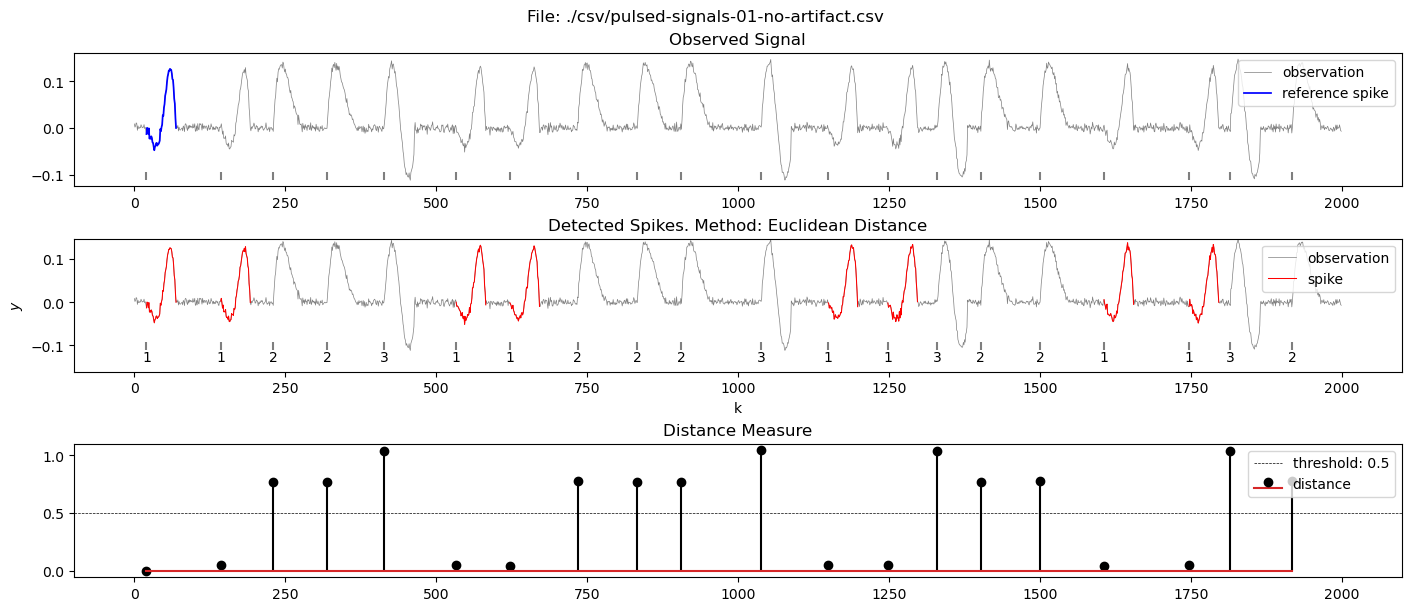

[  20  143  533  622 1149 1248 1606 1747]


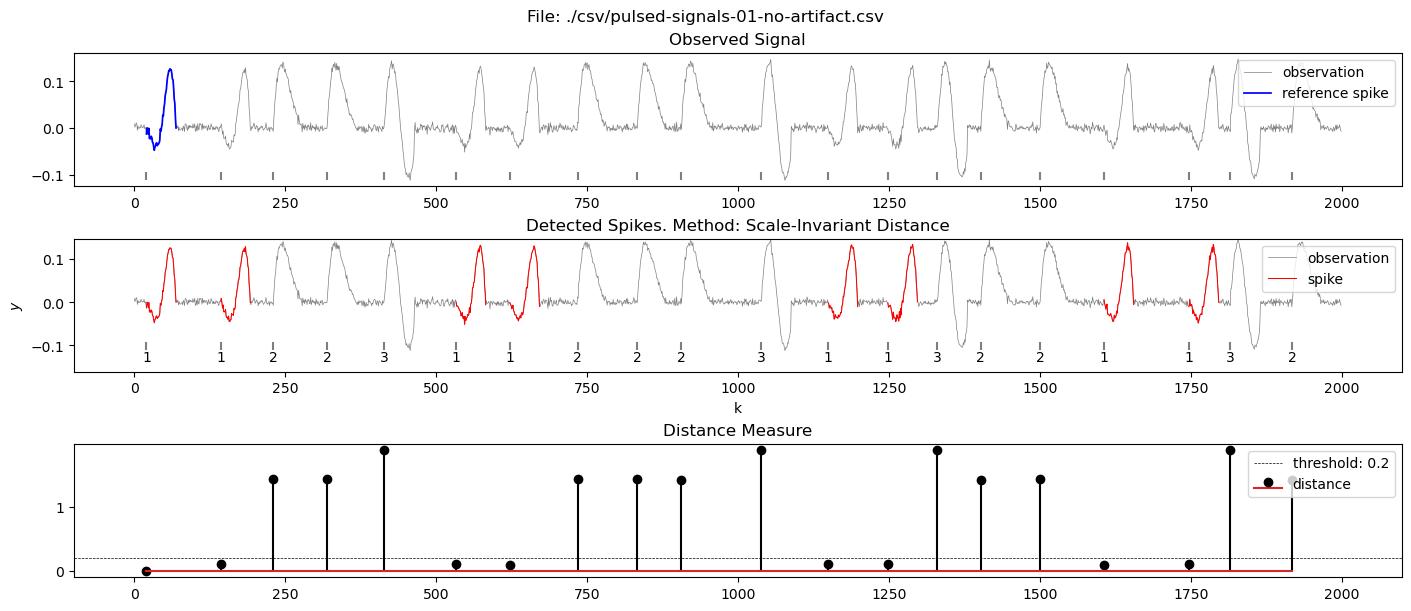

[  20  143  533  622 1149 1248 1606 1747]


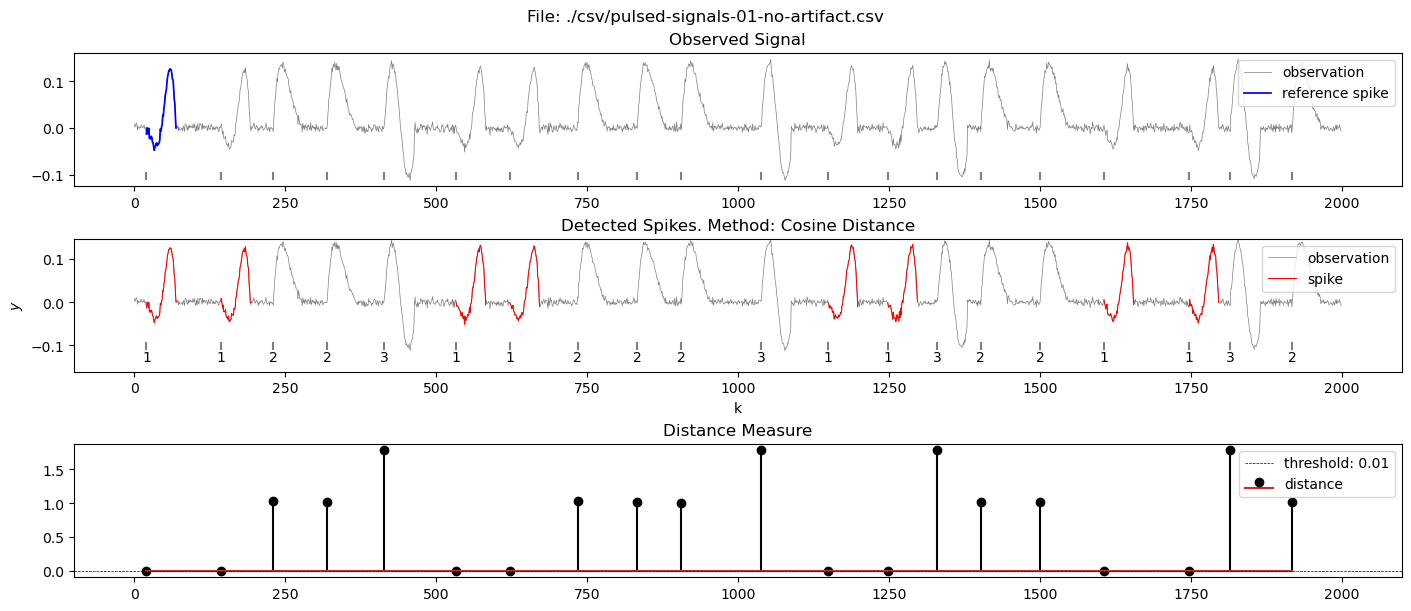

[  20  143  533  622 1149 1248 1606 1747]


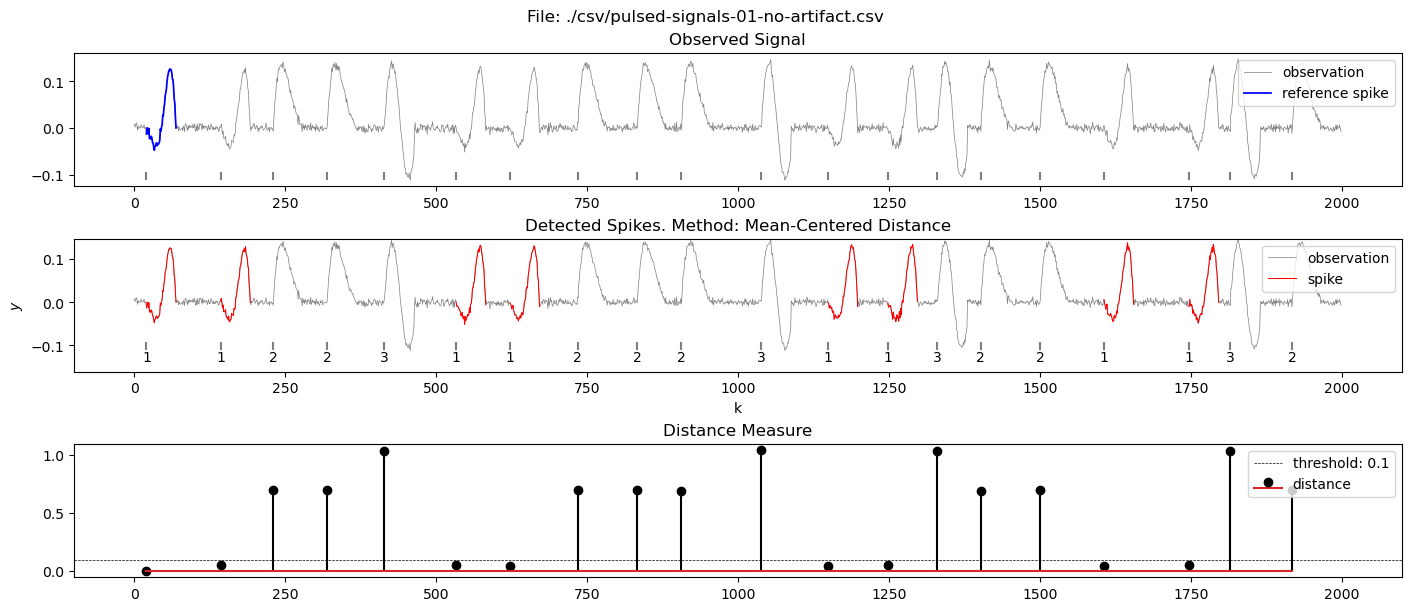

[  20  143  533  622 1149 1248 1606 1747]


In [ ]:
# pulsed-signals-01-no-artifact.csv — Clean spike train recording with only very little artifacts.

FILENAME = get_filename(1) # Task 1, "./csv/pulsed-signals-01-no-artifact.csv"
SAVE_FIGURE = False
DISTANCE_THRESHOLD = 0.5
REF_INDEX = 0
indices_spikes_detected = detect_spikes("euclidean", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.2
REF_INDEX = 0
indices_spikes_detected = detect_spikes("scale_invariant", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

# This is the solution we are probably looking for
DISTANCE_THRESHOLD = 0.01
REF_INDEX = 0
indices_spikes_detected = detect_spikes("cosine", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.1
REF_INDEX = 0
indices_spikes_detected = detect_spikes("mean_centered", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

## Task 2, "./csv/pulsed-signals-02-motion-artifact.csv"

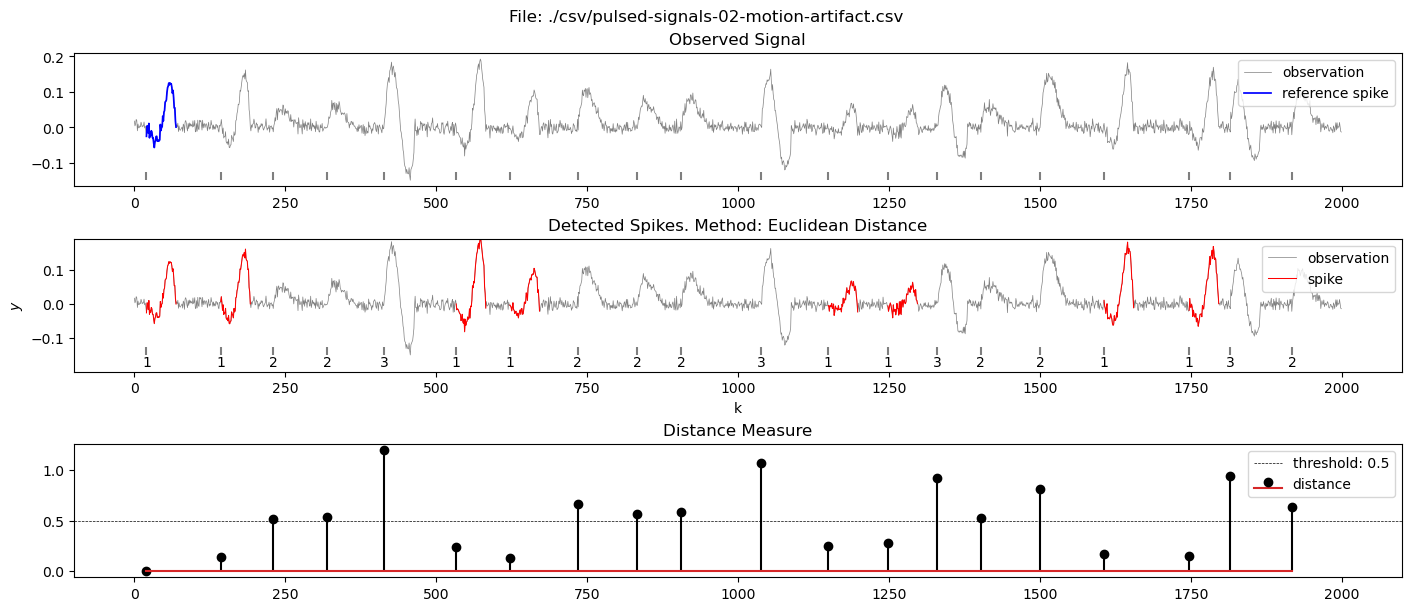

[  20  143  533  622 1149 1248 1606 1747]


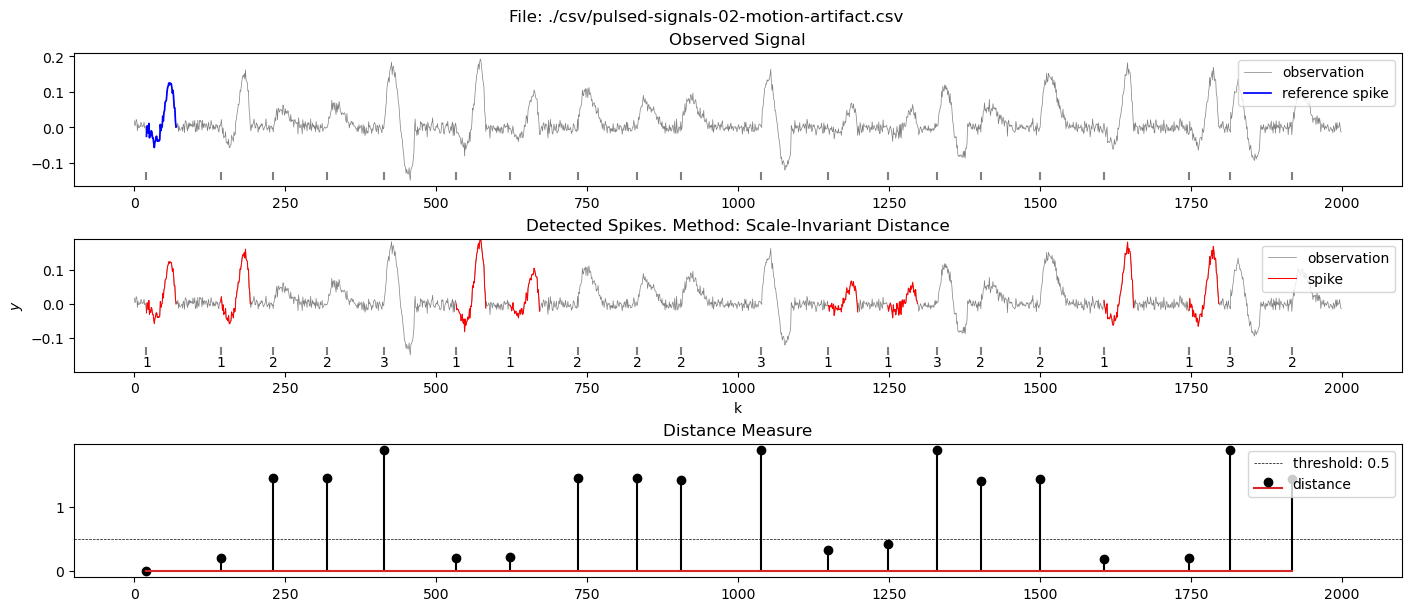

[  20  143  533  622 1149 1248 1606 1747]


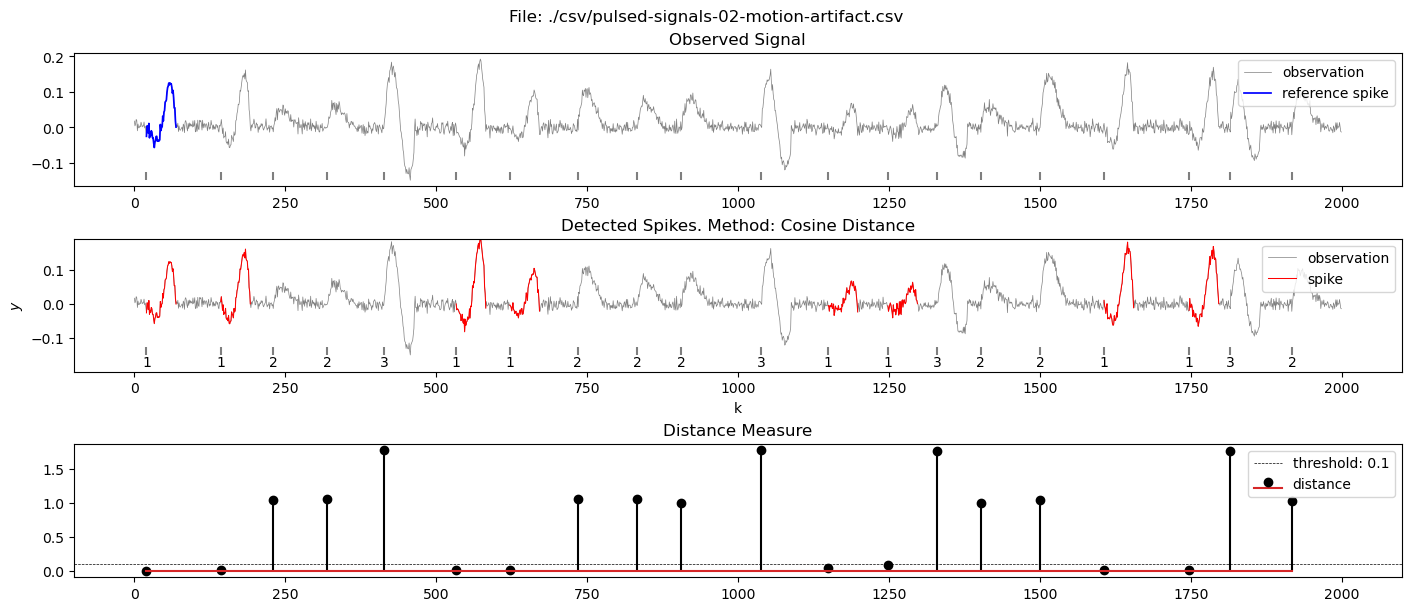

[  20  143  533  622 1149 1248 1606 1747]


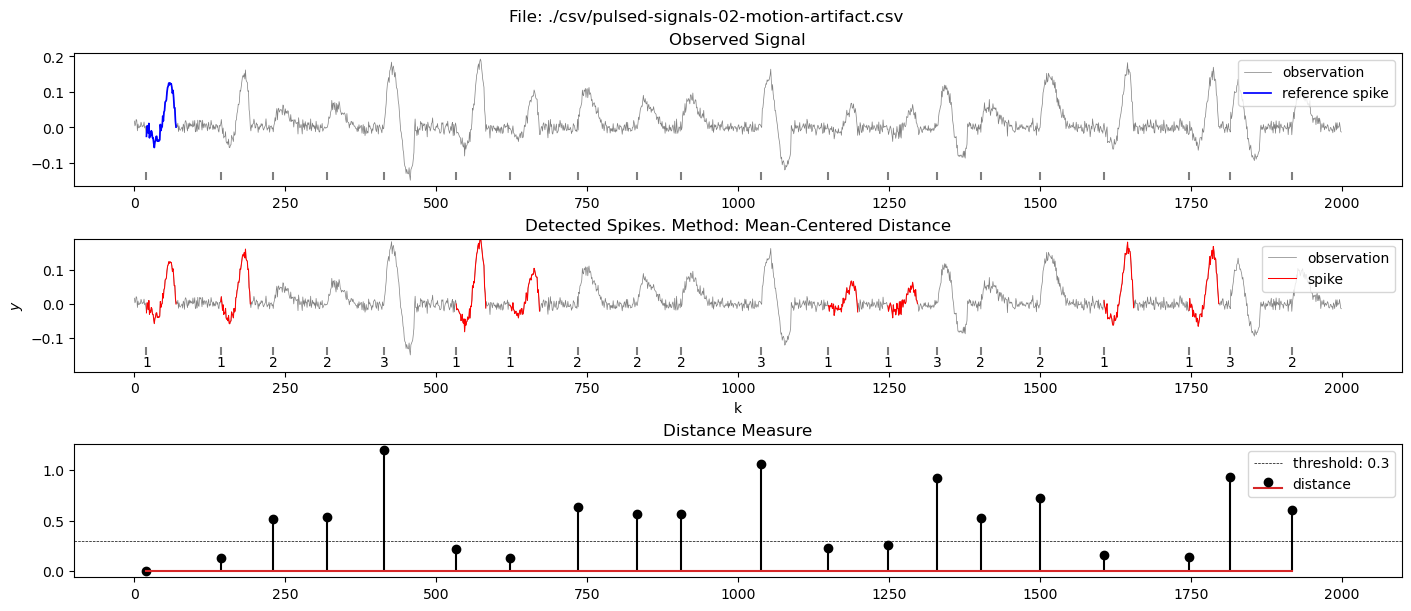

[  20  143  533  622 1149 1248 1606 1747]


In [37]:
# pulsed-signals-02-motion-artifact.csv —Spike train with variable spike amplitudes due to altering distances between sensor and neurone.

FILENAME = get_filename(2) # Task 2, "./csv/pulsed-signals-02-motion-artifact.csv"
SAVE_FIGURE = False
DISTANCE_THRESHOLD = 0.5
REF_INDEX = 0
indices_spikes_detected = detect_spikes("euclidean", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.5
REF_INDEX = 0
indices_spikes_detected = detect_spikes("scale_invariant", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

# This is the solution we are probably looking for
DISTANCE_THRESHOLD = 0.1
REF_INDEX = 0
indices_spikes_detected = detect_spikes("cosine", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.3
REF_INDEX = 0
indices_spikes_detected = detect_spikes("mean_centered", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

## Task 3, "./csv/pulsed-signals-03-motion-artifact-inversion.csv"

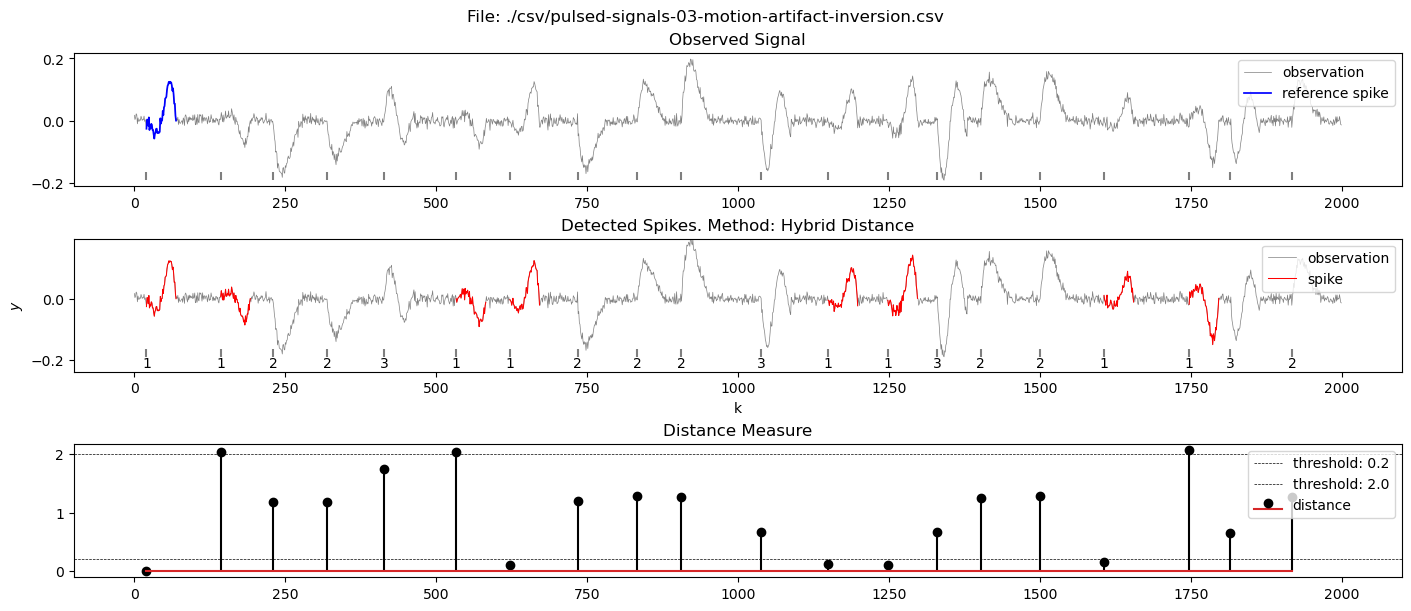

[  20  143  533  622 1149 1248 1606 1747]


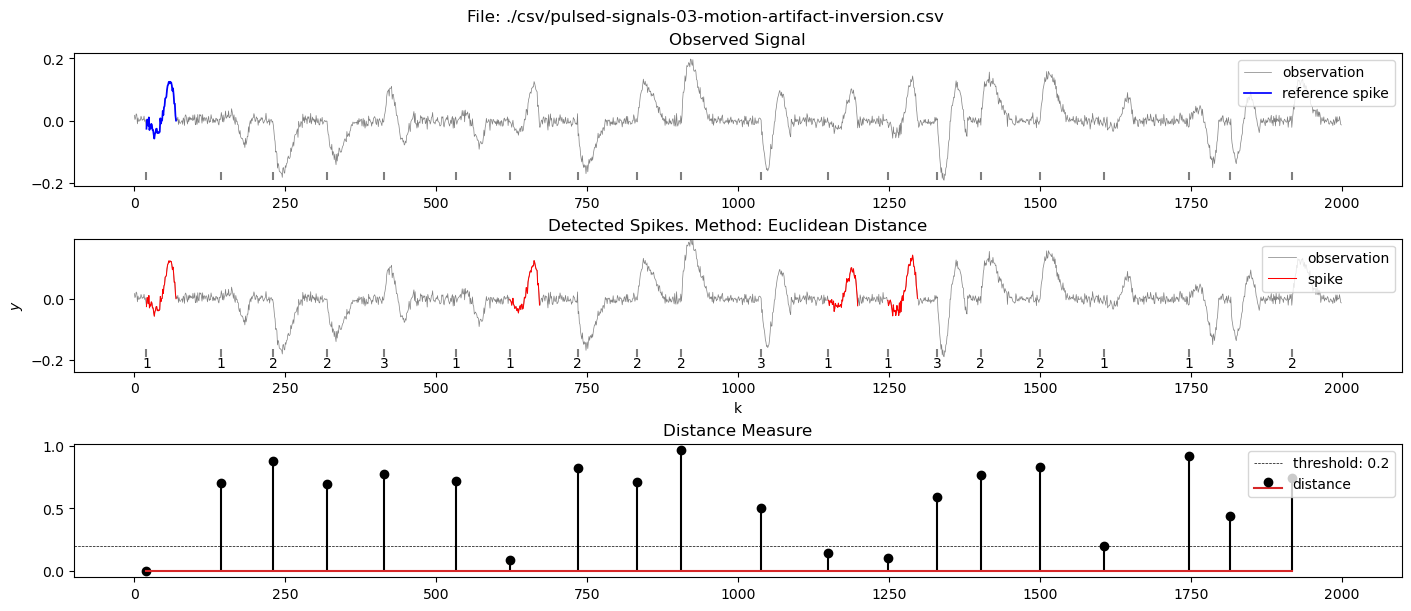

[  20  622 1149 1248]


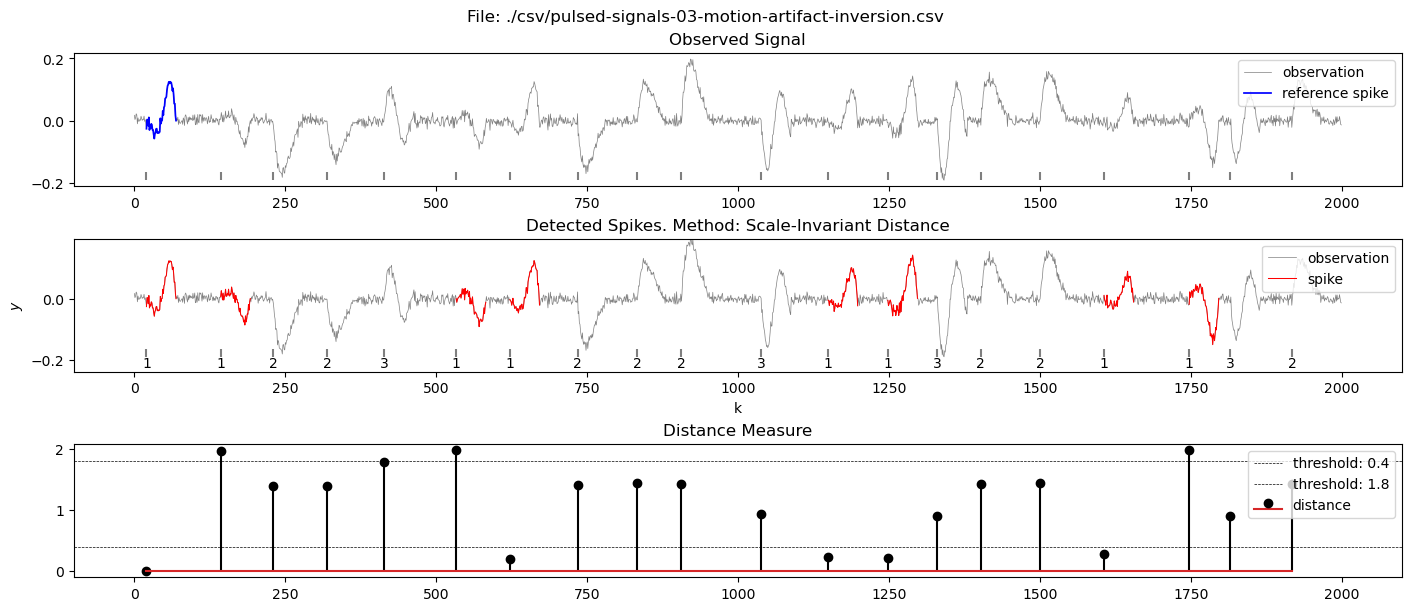

[  20  143  533  622 1149 1248 1606 1747]


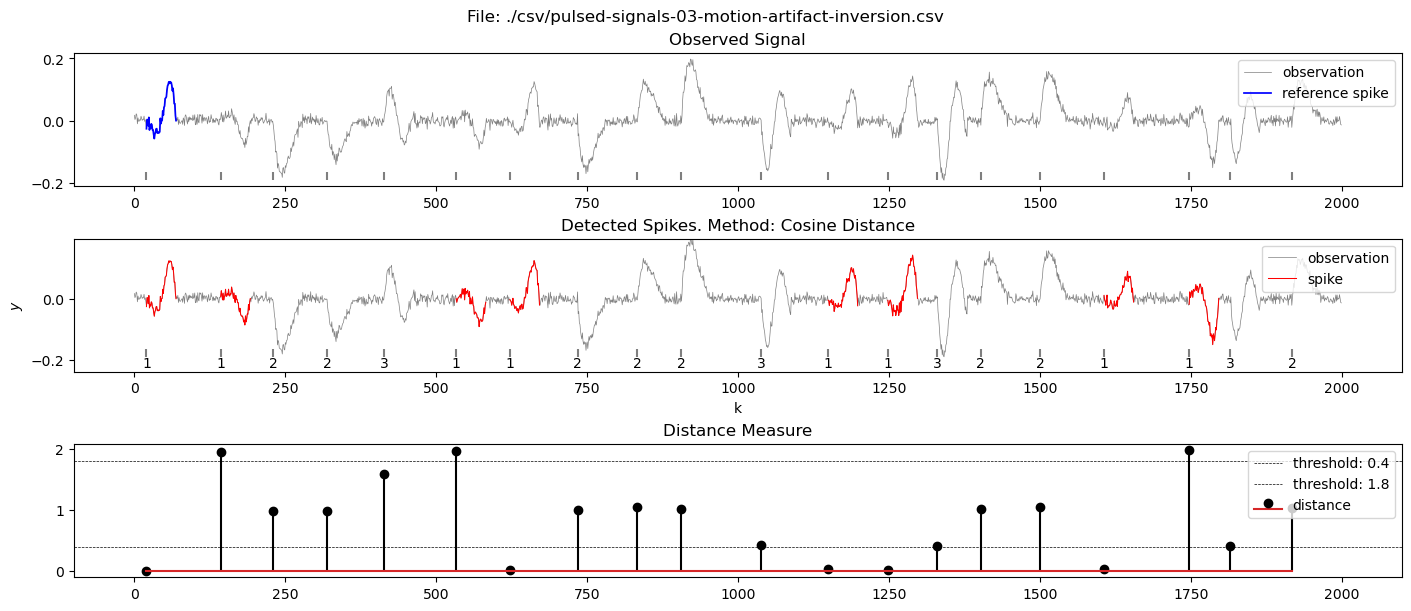

[  20  143  533  622 1149 1248 1606 1747]


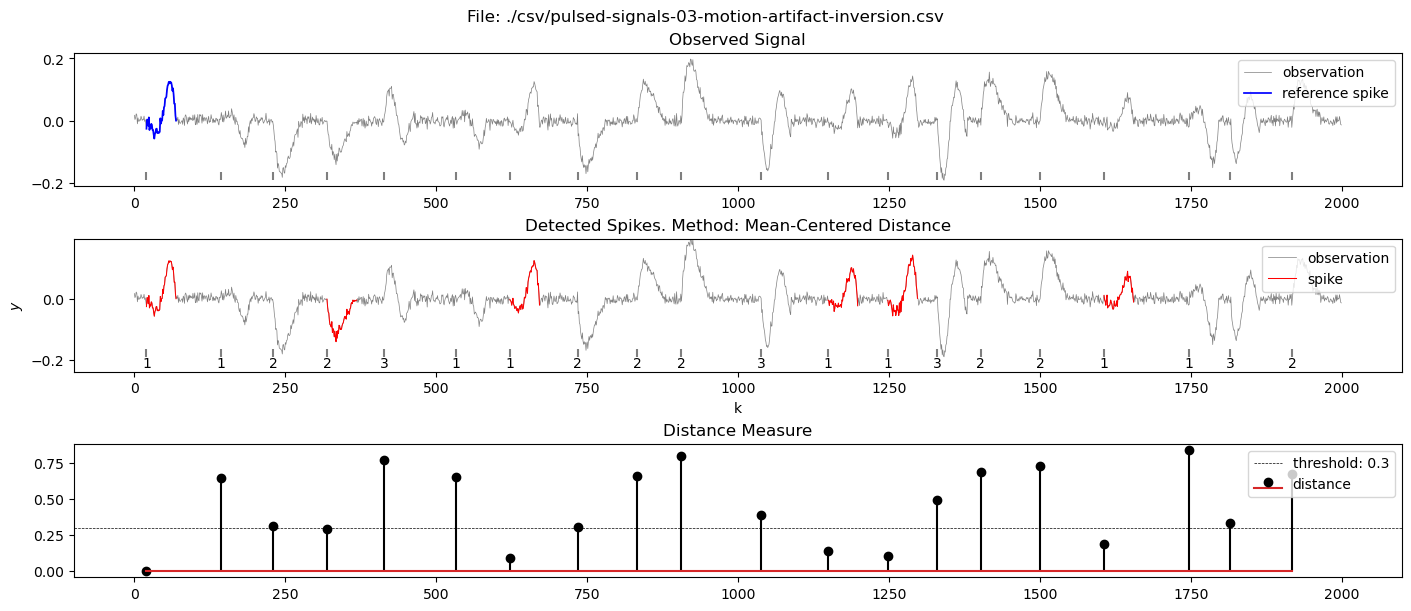

[  20  319  622 1149 1248 1606]


In [85]:
# pulsed-signals-03-motion-artifact-inversion.csv —Spike train also with variable spike amplitudes but possible spike inversion (i.e., some spikes appear with reversed polarity).

FILENAME = get_filename(3) # Task 3, "./csv/pulsed-signals-03-motion-artifact-inversion.csv"
SAVE_FIGURE = False
REF_INDEX = 0

# This is the solution we are probably looking for
SAVE_FIGURE = True
DISTANCE_THRESHOLD = 0.2
TOP_DISTANCE_THRESHOLD = 2.0
hybrid_weights = {'euclidean': 0.0, 'scale_invariant': 0.4, 'cosine': 0.6, 'mean_centered': 0.1}
indices_spikes_detected = detect_spikes("hybrid", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE, TOP_DISTANCE_THRESHOLD, hybrid_weights)
print(indices_spikes_detected)

SAVE_FIGURE = False
DISTANCE_THRESHOLD = 0.2
indices_spikes_detected = detect_spikes("euclidean", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

BOTTOM_DISTANCE_THRESHOLD = 0.4
TOP_DISTANCE_THRESHOLD = 1.8
indices_spikes_detected = detect_spikes("scale_invariant", BOTTOM_DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE, TOP_DISTANCE_THRESHOLD)
print(indices_spikes_detected)

# This is the solution we are probably looking for
SAVE_FIGURE = True
DISTANCE_THRESHOLD = 0.1
TOP_DISTANCE_THRESHOLD = 1.8
indices_spikes_detected = detect_spikes("cosine", BOTTOM_DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE, TOP_DISTANCE_THRESHOLD)
print(indices_spikes_detected)

SAVE_FIGURE = False
DISTANCE_THRESHOLD = 0.3
indices_spikes_detected = detect_spikes("mean_centered", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

## Task 4, "./csv/pulsed-signals-04-baseline-drift.csv"

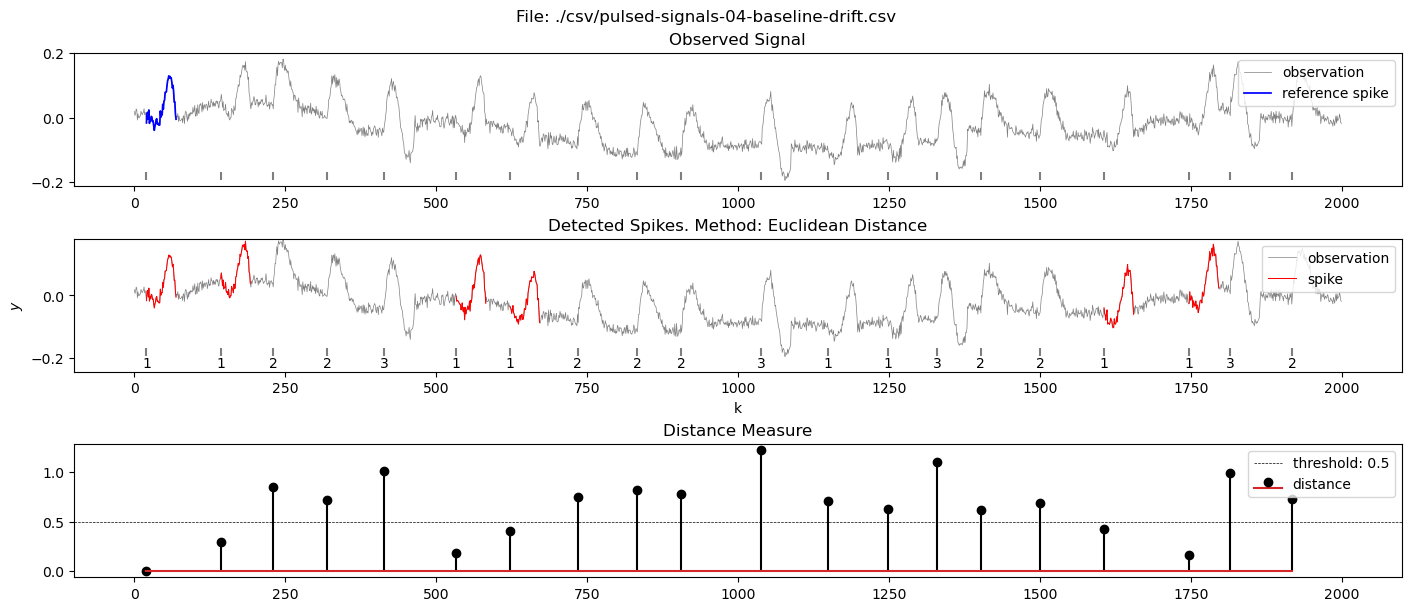

[  20  143  533  622 1606 1747]


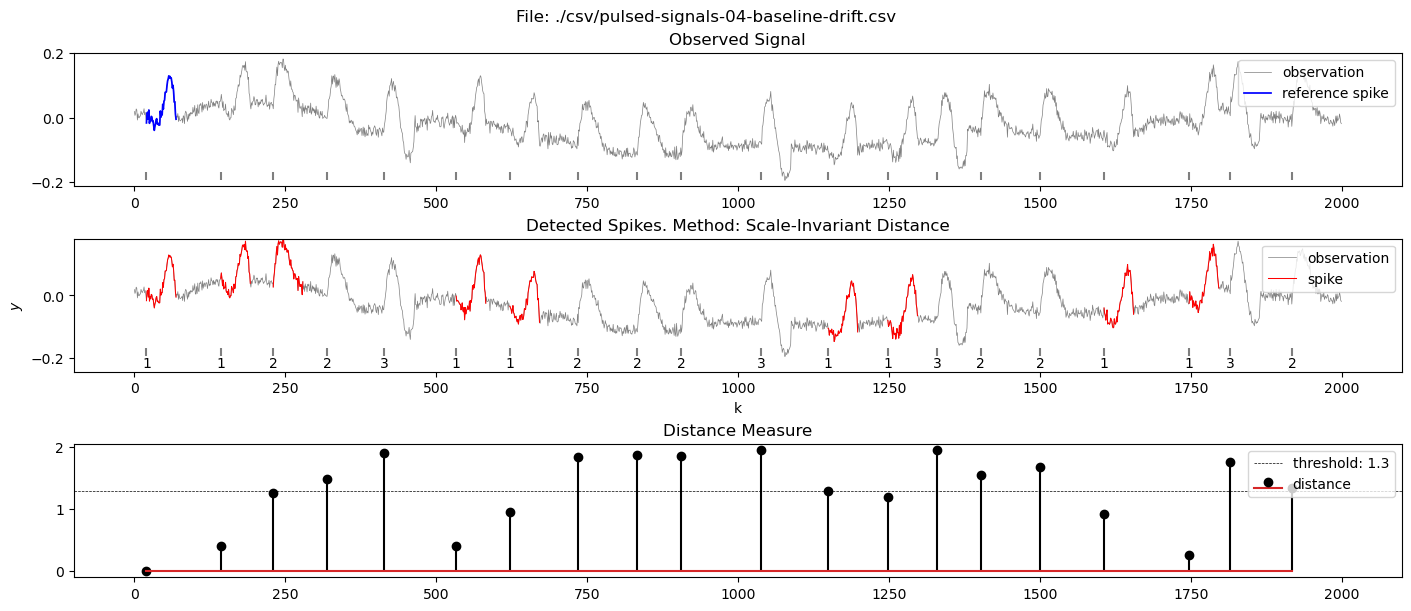

[  20  143  230  533  622 1149 1248 1606 1747]


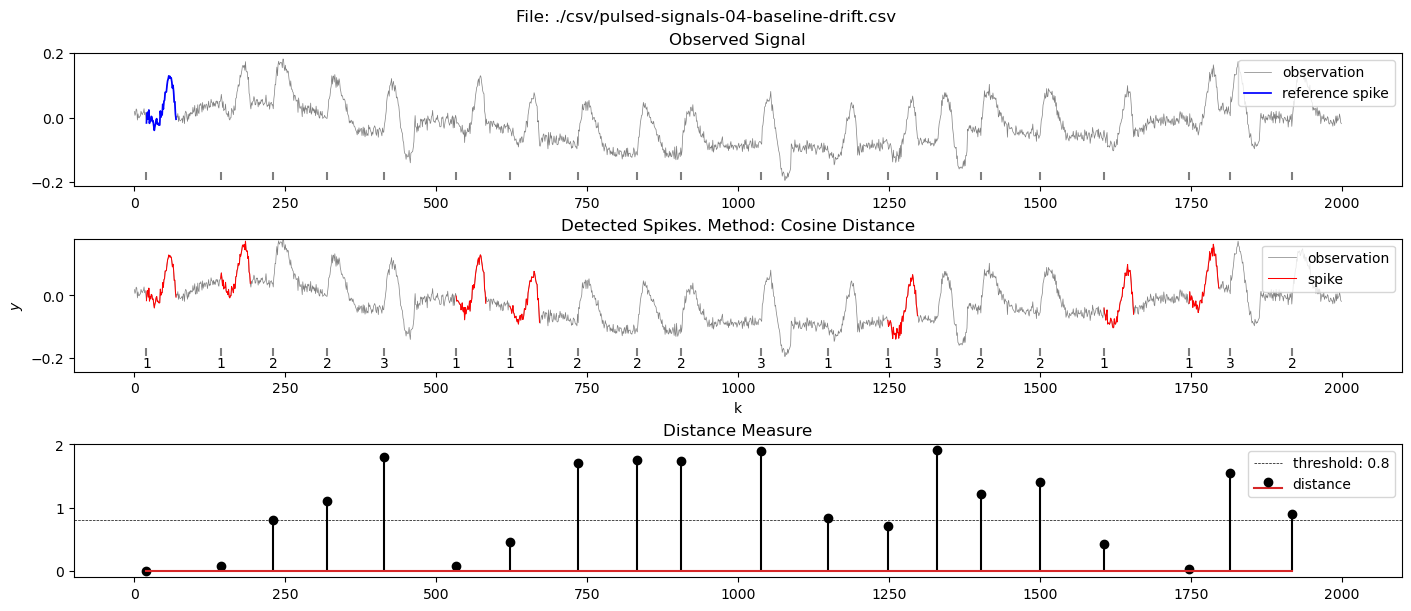

[  20  143  533  622 1248 1606 1747]


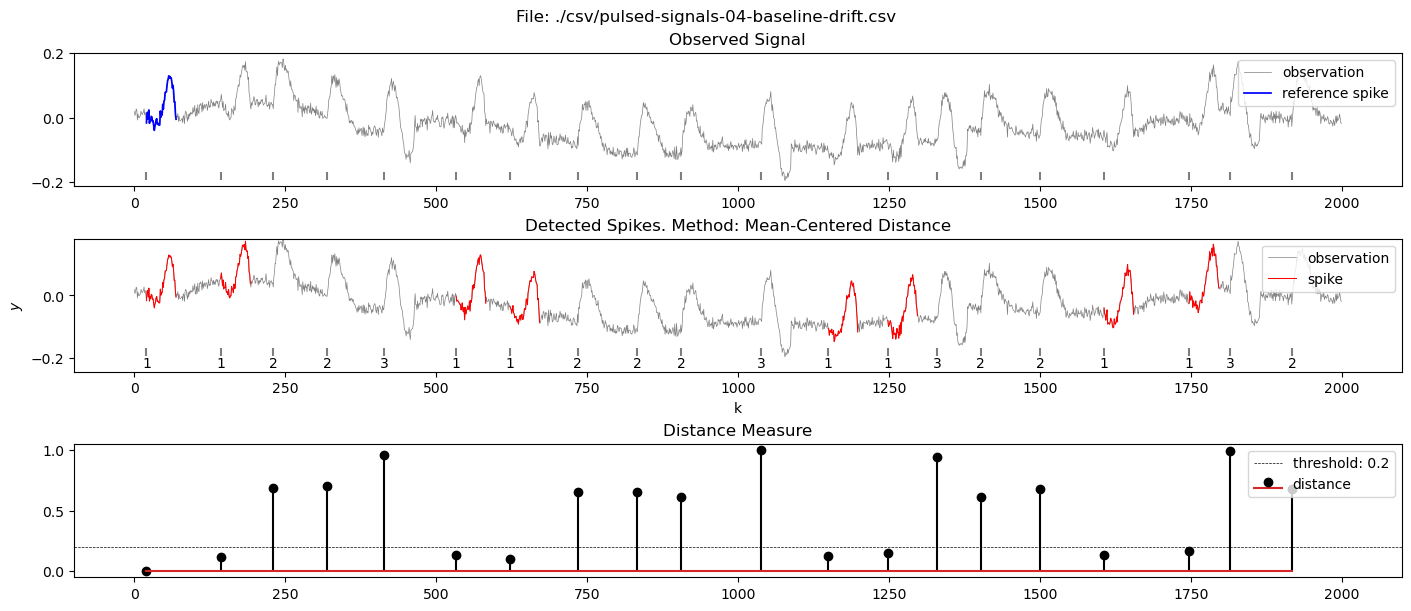

[  20  143  533  622 1149 1248 1606 1747]


In [ ]:
# [optional] pulsed-signals-04-baseline-drift.csv — Spike train with baseline signal drift e.g., due to sensor motion.
 
FILENAME = get_filename(4) # Task 4, "./csv/pulsed-signals-04-baseline-drift.csv"
SAVE_FIGURE = False
REF_INDEX = 0

DISTANCE_THRESHOLD = 0.5
indices_spikes_detected = detect_spikes("euclidean", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

BOTTOM_DISTANCE_THRESHOLD = 1.3
indices_spikes_detected = detect_spikes("scale_invariant", BOTTOM_DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.8
indices_spikes_detected = detect_spikes("cosine", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

# This is the solution we are probably looking for
SAVE_FIGURE = True
DISTANCE_THRESHOLD = 0.2
indices_spikes_detected = detect_spikes("mean_centered", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

## Task 5, "./csv/pulsed-signals-05-strong-distortion.csv"

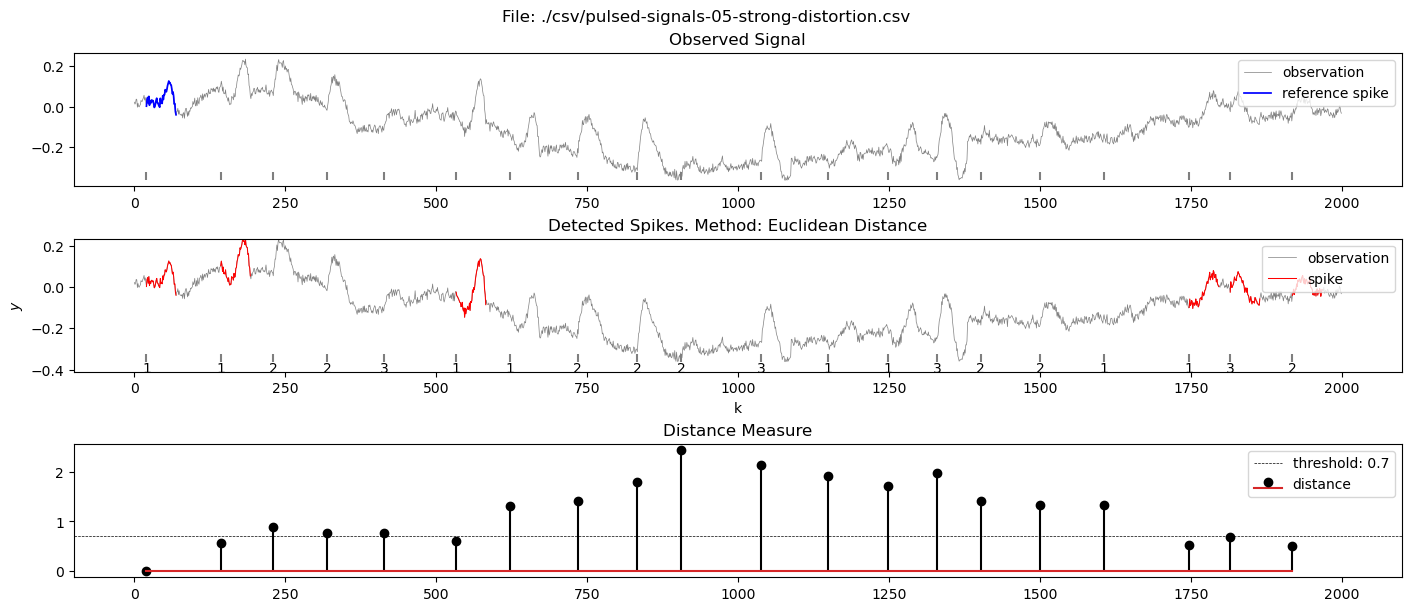

[  20  143  533 1747 1815 1918]


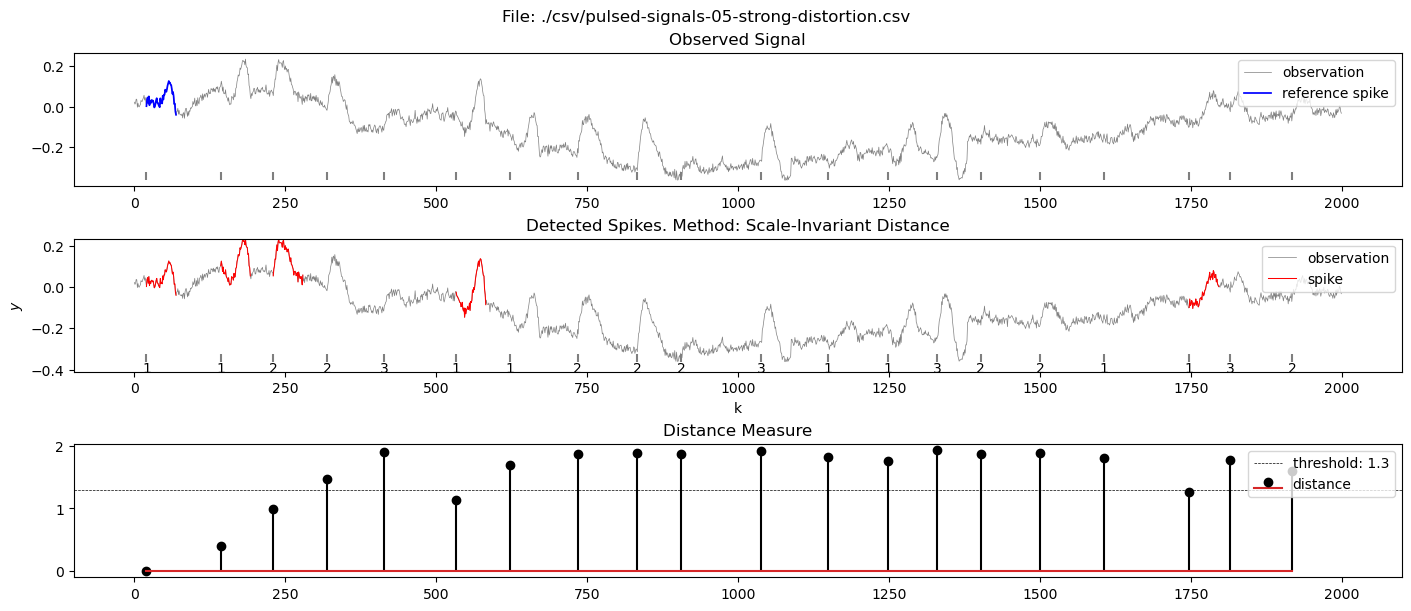

[  20  143  230  533 1747]


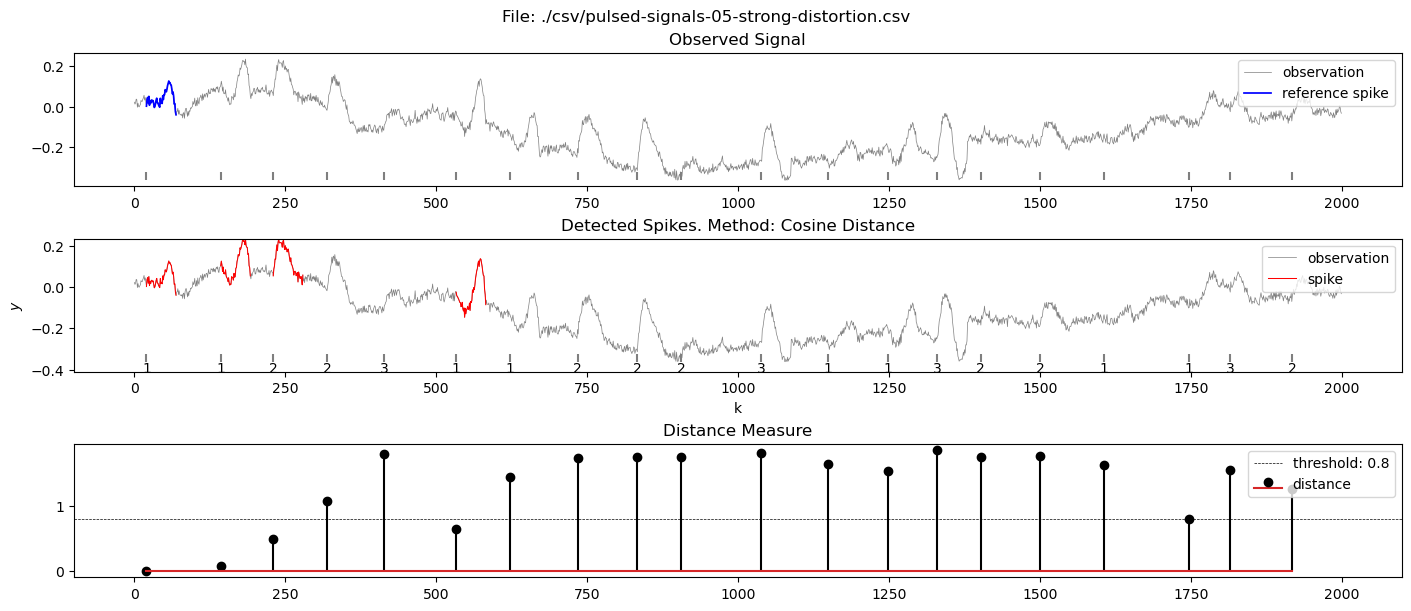

[ 20 143 230 533]


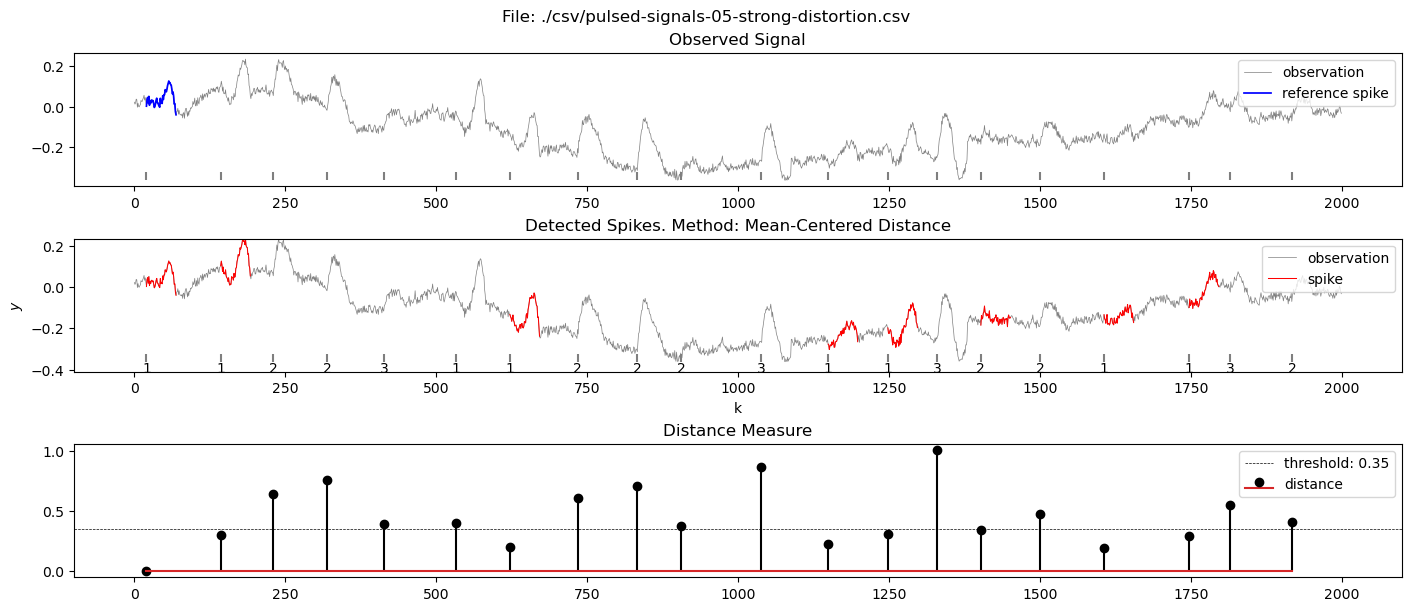

[  20  143  622 1149 1248 1402 1606 1747]


In [126]:
# [optional] pulsed-signals-05-strong-distortion.csv — Spike train with baseline signal drift and variable spike amplitudes e.g., due to severe sensor motion.

FILENAME = get_filename(5) # Task 5, "./csv/pulsed-signals-05-strong-distortion.csv"
SAVE_FIGURE = False
REF_INDEX = 0

DISTANCE_THRESHOLD = 0.7
indices_spikes_detected = detect_spikes("euclidean", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

BOTTOM_DISTANCE_THRESHOLD = 1.3
indices_spikes_detected = detect_spikes("scale_invariant", BOTTOM_DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

DISTANCE_THRESHOLD = 0.8
indices_spikes_detected = detect_spikes("cosine", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

SAVE_FIGURE = True
DISTANCE_THRESHOLD = 0.35
indices_spikes_detected = detect_spikes("mean_centered", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE)
print(indices_spikes_detected)

Best weights based on GridSearch:
{'euclidean': 0.0, 'scale_invariant': 0.1, 'cosine': 0.1, 'mean_centered': 0.8}

Accuracy achieved using best weights:
0.9999999937499999


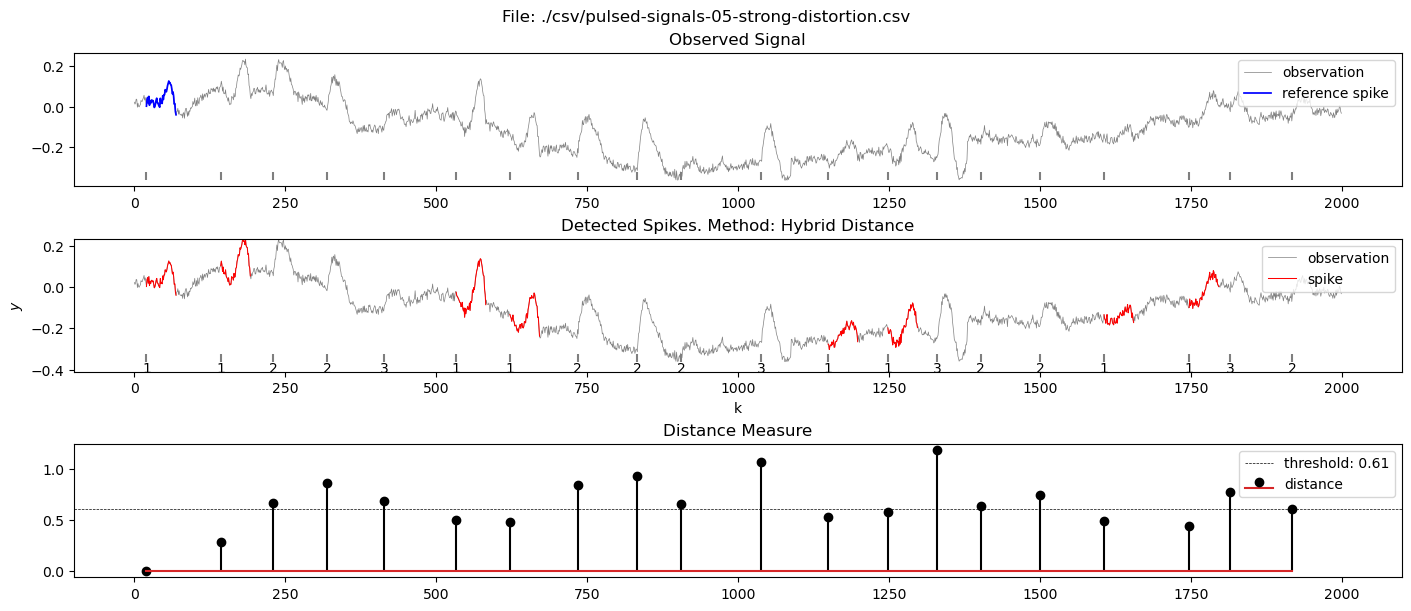

[  20  143  533  622 1149 1248 1606 1747]


In [145]:
DISTANCE_THRESHOLD = 0.61
hybrid_weights = {'euclidean': 0.0, 'scale_invariant': 0.0, 'cosine': 0.0, 'mean_centered': 0.0}

SAVE_FIGURE = True
indices_spikes_detected = detect_spikes("hybrid", DISTANCE_THRESHOLD, REF_INDEX, FILENAME, SAVE_FIGURE, 0, hybrid_weights, True)
print(indices_spikes_detected)